# Mentorship: Revert Rates

In [1]:
library(tidyverse)
library(broom)

library(brms) # install.packages("brms")
# library(loo) # install.packages("loo")
# library(rstanarm) # install.packages("rstanarm")

library(lubridate)

library(lme4)

library(here)

library(ivreg)

Warning message:
“package ‘tidyverse’ was built under R version 4.2.3”
Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘tibble’ was built under R version 4.2.3”
Warning message:
“package ‘tidyr’ was built under R version 4.2.3”
Warning message:
“package ‘readr’ was built under R version 4.2.3”
Warning message:
“package ‘purrr’ was built under R version 4.2.3”
Warning message:
“package ‘dplyr’ was built under R version 4.2.3”
Warning message:
“package ‘stringr’ was built under R version 4.2.3”
Warning message:
“package ‘forcats’ was built under R version 4.2.3”
Warning message:
“package ‘lubridate’ was built under R version 4.2.3”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ──────────────────────────────────────

# R Configuration variables

In [2]:
## NOTE: `loo`, which we use for model comparisons, has a tendency to use lots or run out of memory.
## Therefore, I've often had to set mc.cores to 1 before running it. However, if we set its `pointwise`
## parameter, it'll use less memory. And it'll use BLAS, so we restrict the number of BLAS threads to 1.
## Then mc.cores controls the number of parallel processes.

## blas_set_num_threads() also controls the number of threads that glmer() uses. Depending on the load
## on the server at the time we're doing our analysis we can tune the number of threads.

library(RhpcBLASctl)
blas_set_num_threads(1)
options(mc.cores = 4, digits = 3, scipen = 500)

# Give me wider plots, please
options(repr.plot.width = 14, repr.plot.height = 7)

Warning message:
“package ‘RhpcBLASctl’ was built under R version 4.2.3”


# Configuration variables

In [3]:
## Path to the dataset with user information
user_dataset_filename <- here('datasets', 'mentorship_users.tsv')

## Column types in the user info dataset:
## wiki, experiment group, and platform are all factors,
## registration timestamp is treated as character (parsed by lubridate later),
## the other columns are integers or doubles
user_dataset_column_types <- 'ficffiiflldd'

## Path to the dataset with Welcome Survey responses
survey_dataset_filename <- here('datasets', 'mentorship_survey_responses.tsv')

## Column types in the survey response dataset
survey_dataset_column_types <- 'fifffd'

## Path to the dataset with mentorship question edit data
mentor_edit_dataset_filename <- here('datasets', 'mentorship_edits.tsv')

## Column types in the mentorship question edit data
## We're skipping columns 8 & 9 because wiki_db and user_id are duplicated
mentor_edit_dataset_column_types <- 'ficffdd__iici'

## Wide dataset with editing data, used specifically for this type of analysis
editing_dataset_filename <- here('datasets', 'mentorship_editing_data.tsv')

## Column types in the editing dataset
## wiki, experiment group, and platform are all factors,
## registration timestamp is treated as character (parsed by lubridate later),
## the other columns are integers
editing_dataset_column_types <- 'ficffddiiiiiiiiiiiiiiii'

# Data import and setup

In [4]:
## Function that takes in the filename of the user edit data, reads it in,
## and creates all the various derived columns we need.
read_user_dataset <- function(dataset_filename, dataset_column_types) {
    read_tsv(
        dataset_filename,
        col_types = dataset_column_types) %>%
    mutate(
        # Parse the timestamp
        user_registration_ts = ymd_hms(user_registration),
        # Convert multiple variables to factors or boolean
        wiki_name = ifelse(wiki_db == 'eswiki', 'Spanish', 'English'),
        platform_name = ifelse(platform == 'desktop', 'Desktop', 'Mobile web'),
        has_mentor = ifelse(mentor_enabled == 1, TRUE, FALSE),
        # Number of edits:
        num_total_edits_24hrs = num_article_edits_24hrs + num_other_edits_24hrs,
        num_total_edits_2w = num_article_edits_2w + num_other_edits_2w,
        num_total_edits = num_total_edits_24hrs + num_total_edits_2w,
        num_total_article_edits = num_article_edits_24hrs + num_article_edits_2w,
        num_total_other_edits = num_other_edits_24hrs + num_total_edits_2w,
        num_total_edits_24hrs_no_mentor = num_total_edits_24hrs - num_mentorship_edits_24hrs,
        num_total_edits_2w_no_mentor = num_total_edits_2w - num_mentorship_edits_2w,
        num_total_edits_no_mentor = num_total_edits_24hrs_no_mentor + num_total_edits_2w_no_mentor,
        # Counts of constructive article edits:
        num_const_article_edits = num_article_edits_24hrs + num_article_edits_2w -
                                    num_article_reverts_24hrs - num_article_reverts_2w,
        num_const_article_edits_24hrs = num_article_edits_24hrs - num_article_reverts_24hrs,
        num_const_article_edits_2w = num_article_edits_2w - num_article_reverts_2w,
        # Log number of total edits is used as a control variable in the revert analysis
        log_num_total_edits = log(1 + num_total_edits),
        # Number of reverts:
        num_reverts_24hrs = num_article_reverts_24hrs + num_other_reverts_24hrs,
        num_reverts_2w = num_article_reverts_2w + num_other_reverts_2w,
        num_total_reverts = num_reverts_24hrs + num_reverts_2w,
        ## Control variables for the number of edits made (used for ex. in revert analysis)
        log_num_article_edits_24hrs = log(1 + num_article_edits_24hrs),
        log_num_other_edits_24hrs = log(1 + num_other_edits_24hrs),
        log_num_edits_24hrs = log(1 + num_article_edits_24hrs + num_other_edits_24hrs),
        # Control variables for the number of constructive edits made
        log_num_const_article_edits_24hrs = log(
            1 + num_article_edits_24hrs - num_article_reverts_24hrs),
        log_num_const_other_edits_24hrs = log(
            1 + num_other_edits_24hrs - num_other_reverts_24hrs),
        log_num_const_edits_24hrs = log(
            1 + num_article_edits_24hrs + num_other_edits_24hrs -
                num_article_reverts_24hrs - num_other_reverts_24hrs),
        log_num_edits_24hrs_no_mentor = log(1 + num_total_edits_24hrs_no_mentor),
        # Revert rate:
        prop_rev_edits = ifelse(num_total_edits > 0, num_total_reverts / num_total_edits, 0),
        # Did they activate?
        is_activated_article = num_article_edits_24hrs > 0,
        is_activated_other = num_other_edits_24hrs > 0,
        is_activated = is_activated_article | is_activated_other,
        # Did they activate through constructive edits?
        is_const_activated_article = (num_article_edits_24hrs - num_article_reverts_24hrs) > 0,
        is_const_activated_other = (num_other_edits_24hrs - num_other_reverts_24hrs) > 0,
        is_const_activated = is_const_activated_article | is_const_activated_other,
        # Did they activate through mentorship?
        is_activated_mentor = num_mentorship_edits_24hrs > 0,
        # Did they activate for other reasons than asking their mentor?
        is_activated_no_mentor = num_total_edits_24hrs_no_mentor > 0,
        # Were they retained?
        is_retained_article = is_activated_article & (num_article_edits_2w > 0),
        is_retained_other = is_activated_other & (num_other_edits_2w > 0),
        is_retained = is_activated & ((num_article_edits_2w + num_other_edits_2w) > 0),
        # Were they retained through constructive edits?
        is_const_retained_article = is_const_activated_article &
            ((num_article_edits_2w - num_article_reverts_2w) > 0),
        is_const_retained_other = is_const_activated_other &
            ((num_other_edits_2w - num_other_reverts_2w) > 0),
        is_const_retained = is_const_activated &
            ((num_article_edits_2w + num_other_edits_2w -
              num_article_reverts_2w - num_other_reverts_2w) > 0),
        # Were they retained when we keep mentor questions out?
        is_retained_no_mentor = is_activated_no_mentor & (num_total_edits_2w_no_mentor > 0),
        ## Log number of edits without mentor questions are outcome variables in the 2SLS,
        ## and the number of constructive article edits is too
        log_num_total_edits_24hrs_no_mentor = log(1 + num_total_edits_24hrs_no_mentor),
        log_num_total_edits_2w_no_mentor = log(1 + num_total_edits_2w_no_mentor),
        log_num_total_edits_no_mentor = log(1 + num_total_edits_no_mentor),
        log_num_const_article_edits = log(1 + num_const_article_edits),
        log_num_const_article_edits_2w = log(1 + num_const_article_edits_2w)
    ) 
}

In [16]:
editing_data <- read_user_dataset(editing_dataset_filename, editing_dataset_column_types)

In [17]:
nrow(editing_data)

[1] 133829

## Checking number of accounts for each wiki

We might be looking at very small wikis, in case we might want to not include them in the analysis.

In [ ]:
editing_data %>%
    group_by(wiki_db, platform, mentor_enabled) %>%
    summarize(n = n())

We filter out users with `mentor_enabled` set to 2 because they're so few of them. I suspect they disabled mentorship themselves.

In [19]:
editing_data <- editing_data |>
    filter(mentor_enabled < 2)

In [ ]:
editing_data |>
    group_by(wiki_db, platform, mentor_enabled) |>
    summarize(n = n()) |>
    mutate(per_group = sum(n)) |>
    mutate(perc = 100 * n / per_group)

In [21]:
editing_data |>
    group_by(wiki_db, mentor_enabled) |>
    tally() |>
    mutate(per_group = sum(n)) |>
    mutate(perc = 100 * n / per_group)

wiki_db mentor_enabled n      per_group perc
1 enwiki  0              101739 114509    88.8
2 enwiki  1               12770 114509    11.2
3 eswiki  0                9646  19305    50.0
4 eswiki  1                9659  19305    50.0

# Some statistics

In [28]:
editing_data |>
    filter(num_total_edits > 0) |>
    group_by(wiki_db, platform, has_mentor) |>
    summarize(n = n(),
              mean_total_edits = mean(num_total_edits),
              median_total_edits = median(num_total_edits),
              mean_revert_rate = mean(prop_rev_edits),
              median_revert_rate = median(prop_rev_edits)
              )

`summarise()` has grouped output by 'wiki_db', 'platform'. You can override
using the `.groups` argument.


wiki_db platform has_mentor n     mean_total_edits median_total_edits
1 enwiki  mobile   FALSE      13660 4.38             2                 
2 enwiki  mobile    TRUE       1772 4.02             1                 
3 enwiki  desktop  FALSE      25211 5.09             2                 
4 enwiki  desktop   TRUE       3262 5.88             2                 
5 eswiki  mobile   FALSE       1610 5.14             2                 
6 eswiki  mobile    TRUE       1709 4.11             2                 
7 eswiki  desktop  FALSE       2069 4.81             2                 
8 eswiki  desktop   TRUE       2182 4.65             2                 
  mean_revert_rate median_revert_rate
1 0.330            0                 
2 0.335            0                 
3 0.215            0                 
4 0.225            0                 
5 0.331            0                 
6 0.303            0                 
7 0.249            0                 
8 0.227            0

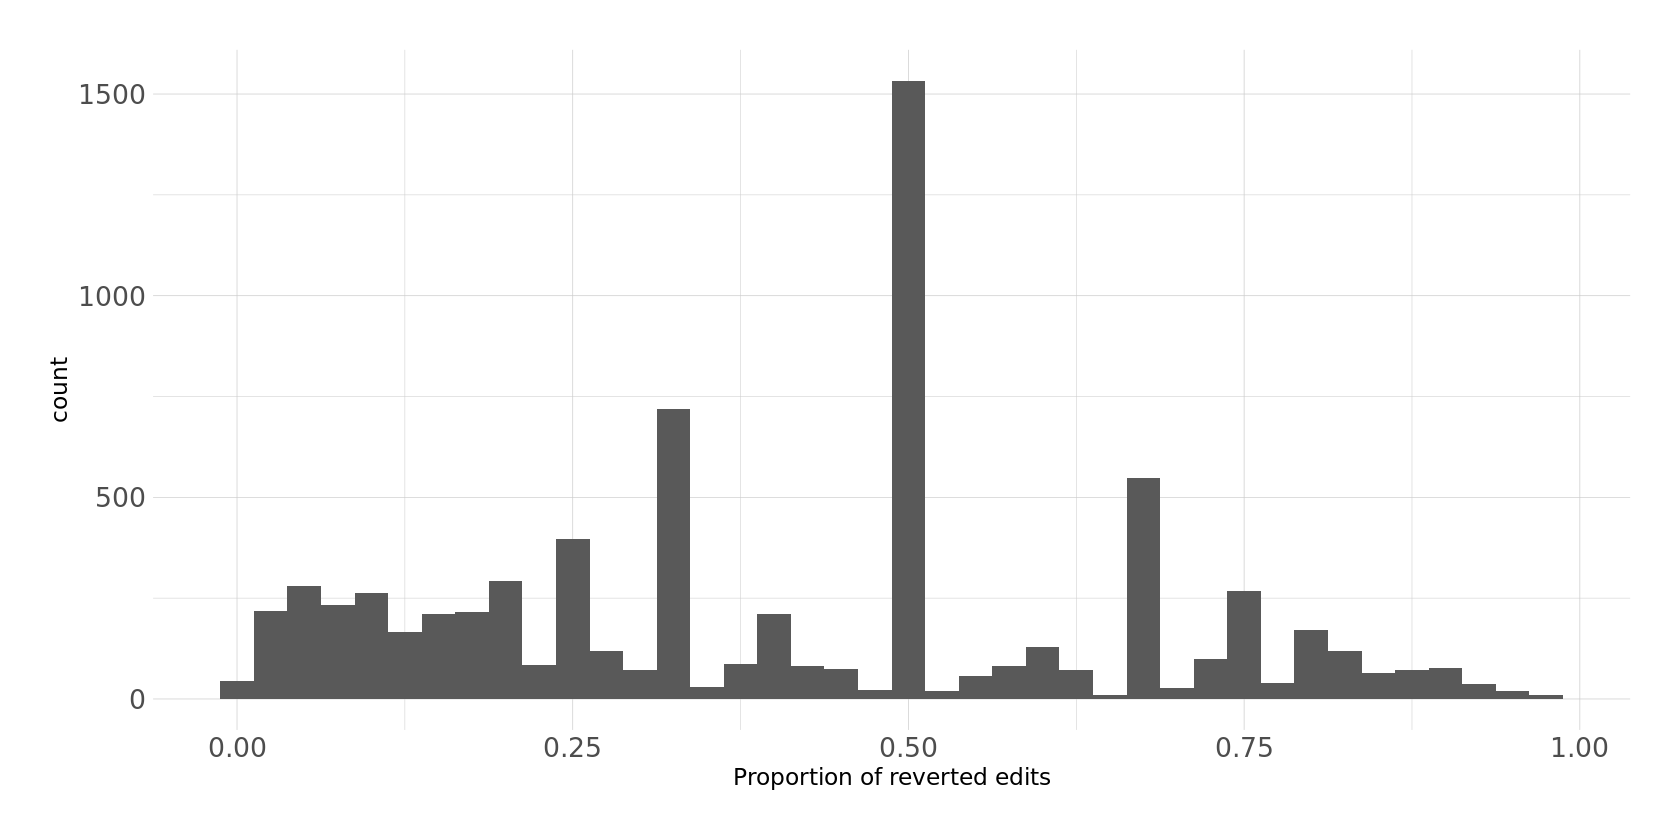

In [24]:
options(repr.plot.width = 14, repr.plot.height = 7)

editing_data %>%
    filter(num_total_edits > 0 & prop_rev_edits > 0 & prop_rev_edits < 1) %>%
    ggplot(aes(x = prop_rev_edits)) +
    geom_histogram(binwidth = 0.025) +
    hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold", strip_text_size = 18,
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14,
                            axis_title_just = 'cm') +
    scale_x_continuous("Proportion of reverted edits")

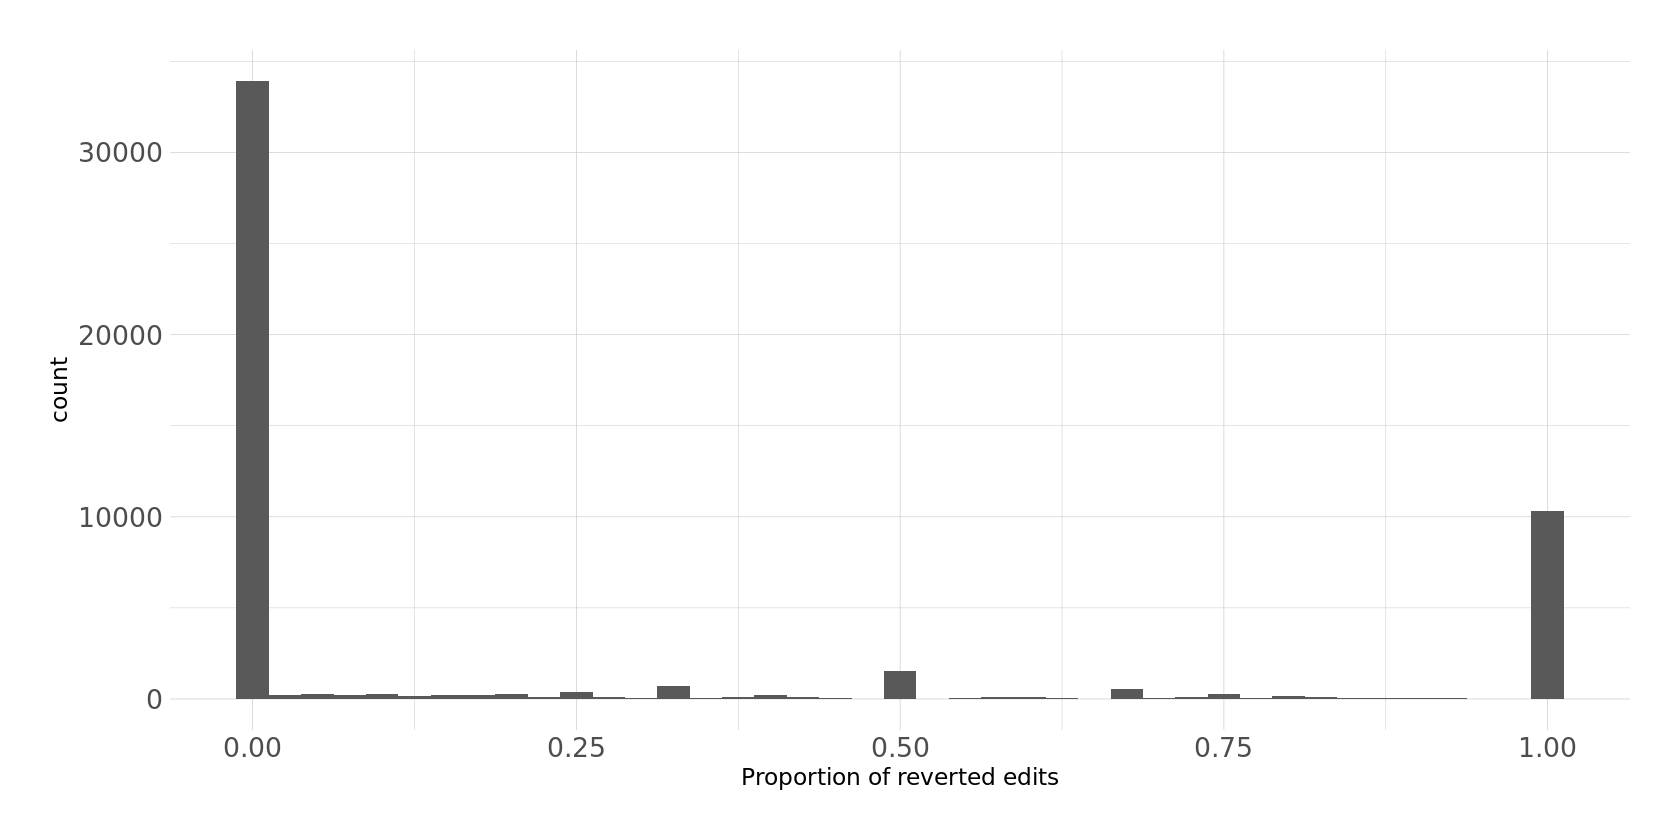

In [23]:
editing_data %>%
    filter(num_total_edits > 0) %>%
    ggplot(aes(x = prop_rev_edits)) +
    geom_histogram(binwidth = 0.025) +
    hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold", strip_text_size = 18,
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14,
                            axis_title_just = 'cm') +
    scale_x_continuous("Proportion of reverted edits")

## Revert rate split by wiki, platform, and group

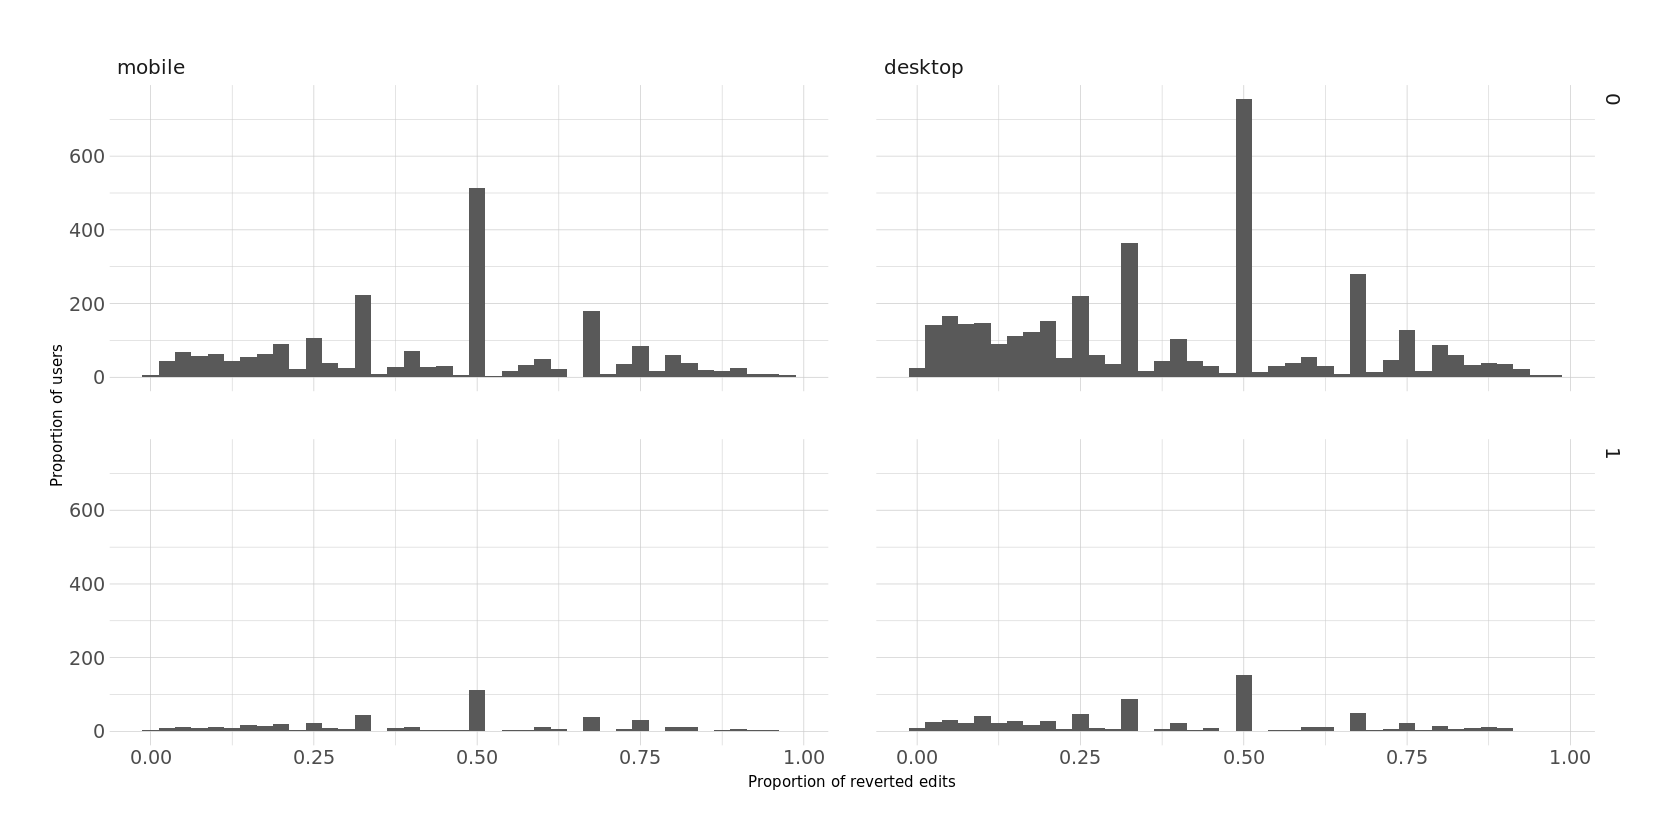

In [25]:
editing_data %>%
    filter(num_total_edits > 0 & prop_rev_edits > 0 & prop_rev_edits < 1) %>%
    ggplot(aes(x = prop_rev_edits)) +
    geom_histogram(binwidth = 0.025) +
    facet_grid(mentor_enabled ~ platform) +
    hrbrthemes::theme_ipsum("DejaVu Sans", axis_title_just = 'cm') +
    labs(x = 'Proportion of reverted edits', y = 'Proportion of users')

Warning message:
“The dot-dot notation (`..count..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(count)` instead.”


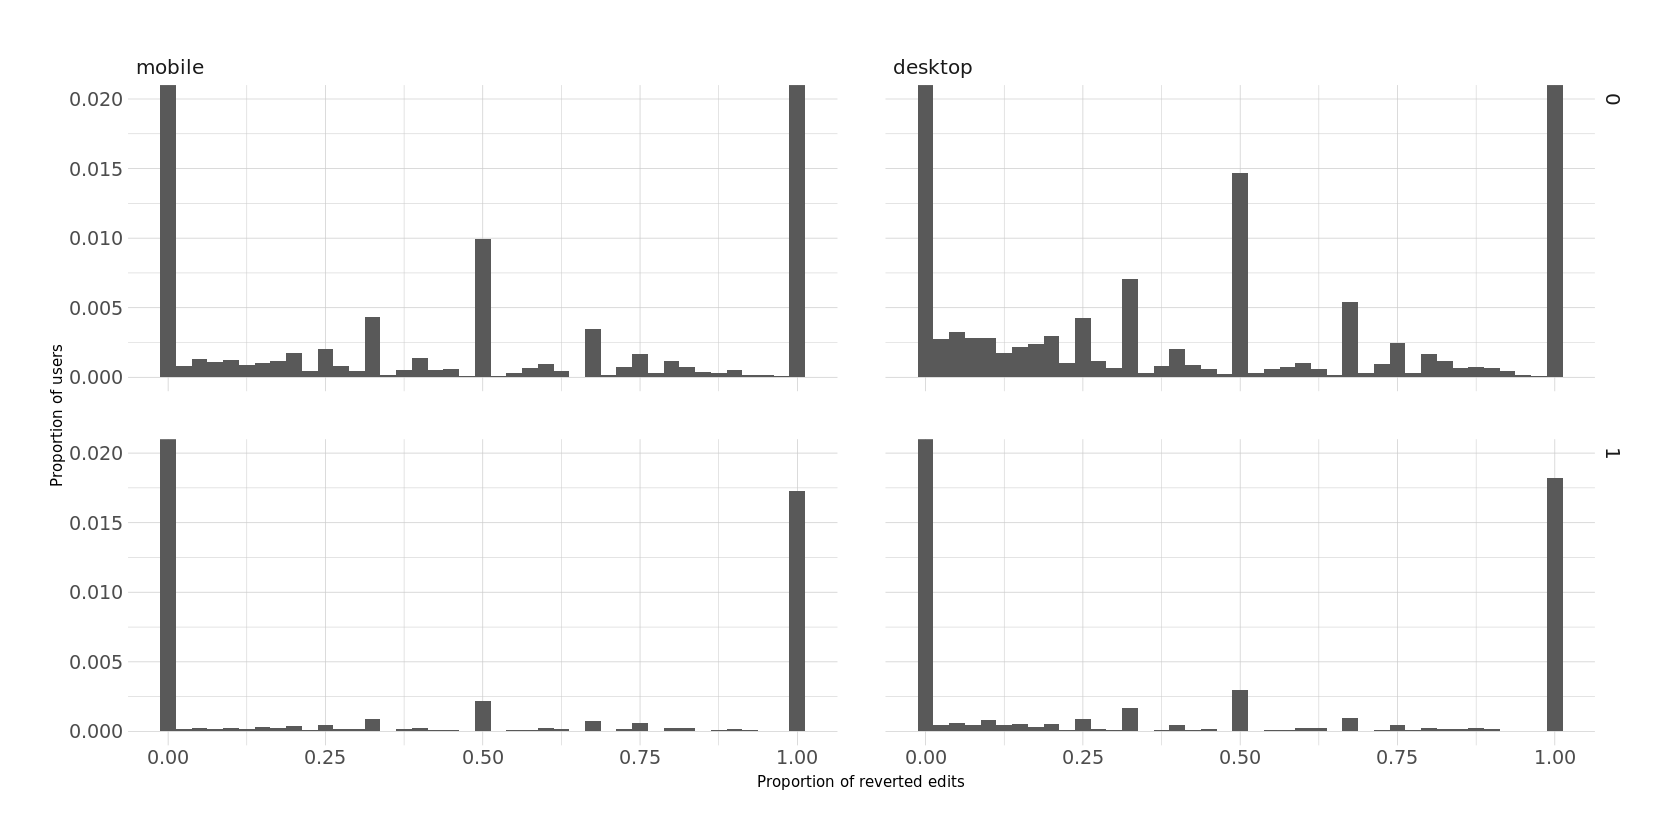

In [26]:
editing_data %>%
    filter(num_total_edits > 0) %>%
    ggplot(aes(x = prop_rev_edits)) +
    geom_histogram(binwidth = 0.025, aes(y = ..count.. / sum(..count..))) +
    facet_grid(mentor_enabled ~ platform) +
    coord_cartesian(ylim = c(0, 0.02)) +
    hrbrthemes::theme_ipsum("DejaVu Sans", axis_title_just = 'cm') +
    labs(x = 'Proportion of reverted edits', y = 'Proportion of users')

# Models

## Overall revert rate

### English

In [29]:
zoib_overall_formula.1 <- bf(
  prop_rev_edits ~ has_mentor + log_num_total_edits + platform,
  phi ~ has_mentor + log_num_total_edits + platform,
  zoi ~ has_mentor + log_num_total_edits + platform,
  coi ~ has_mentor + log_num_total_edits + platform,
  family = zero_one_inflated_beta()
)

In [39]:
enwiki.overall.model.1 <- editing_data |>
    filter(
        wiki_db == 'enwiki' &
        num_total_edits > 0
    ) |>
    brm(
        formula = zoib_overall_formula,
        iter = 200,
    )

Compiling Stan program...

recompiling to avoid crashing R session

Start sampling

Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#tail-ess”


In [40]:
## save the model for reference
save(enwiki.overall.model.1,
     file = here('models', 'mentorship', 'enwiki.overall.model.1.Robj'))

In [41]:
summary(enwiki.overall.model.1)

Warning message:
“The ESS has been capped to avoid unstable estimates.”
Warning message:
“The ESS has been capped to avoid unstable estimates.”
Warning message:
“The ESS has been capped to avoid unstable estimates.”
Warning message:
“The ESS has been capped to avoid unstable estimates.”


 Family: zero_one_inflated_beta 
  Links: mu = logit; phi = log; zoi = logit; coi = logit 
Formula: prop_rev_edits ~ has_mentor + log_num_total_edits + platform 
         phi ~ has_mentor + log_num_total_edits + platform
         zoi ~ has_mentor + log_num_total_edits + platform
         coi ~ has_mentor + log_num_total_edits + platform
   Data: filter(editing_data, wiki_db == "enwiki" & log_num (Number of observations: 43905) 
  Draws: 4 chains, each with iter = 200; warmup = 100; thin = 1;
         total post-warmup draws = 400

Population-Level Effects: 
                        Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
Intercept                   0.37      0.03     0.30     0.43 1.02      598
phi_Intercept               3.09      0.06     2.98     3.20 1.01      594
zoi_Intercept               4.10      0.04     4.01     4.18 1.02     1041
coi_Intercept              -0.41      0.03    -0.48    -0.35 1.01     1041
has_mentorTRUE              0.03      0.03    -0.03     0.08 

Let's look for some interactions.

In [45]:
zoib_overall_formula.2 <- bf(
  prop_rev_edits ~ has_mentor * log_num_total_edits * platform,
  phi ~ has_mentor * log_num_total_edits * platform,
  zoi ~ has_mentor * log_num_total_edits * platform,
  coi ~ has_mentor * log_num_total_edits * platform,
  family = zero_one_inflated_beta()
)

In [46]:
enwiki.overall.model.2 <- editing_data |>
    filter(
        wiki_db == 'enwiki' &
        num_total_edits > 0
    ) |>
    brm(
        formula = zoib_overall_formula.2,
        iter = 400,
    )

Compiling Stan program...

recompiling to avoid crashing R session

Start sampling

Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess”


In [47]:
## save the model for reference
save(enwiki.overall.model.2,
     file = here('models', 'mentorship', 'enwiki.overall.model.2.Robj'))

In [48]:
summary(enwiki.overall.model.2)

 Family: zero_one_inflated_beta 
  Links: mu = logit; phi = log; zoi = logit; coi = logit 
Formula: prop_rev_edits ~ has_mentor * log_num_total_edits * platform 
         phi ~ has_mentor * log_num_total_edits * platform
         zoi ~ has_mentor * log_num_total_edits * platform
         coi ~ has_mentor * log_num_total_edits * platform
   Data: filter(editing_data, wiki_db == "enwiki" & num_tot (Number of observations: 43905) 
  Draws: 4 chains, each with iter = 400; warmup = 200; thin = 1;
         total post-warmup draws = 800

Population-Level Effects: 
                                                       Estimate Est.Error
Intercept                                                  0.27      0.05
phi_Intercept                                              3.23      0.09
zoi_Intercept                                              4.49      0.08
coi_Intercept                                             -0.61      0.04
has_mentorTRUE                                            -0.08   

**Note:** Looks like we have a similar interaction as we've seen in our retention analysis: `platform` interacts with `num_total_edits`. We'll therefore fit a third model that only uses that interaction.

In [49]:
zoib_overall_formula.3 <- bf(
  prop_rev_edits ~ has_mentor + log_num_total_edits * platform,
  phi ~ has_mentor + log_num_total_edits * platform,
  zoi ~ has_mentor + log_num_total_edits * platform,
  coi ~ has_mentor + log_num_total_edits * platform,
  family = zero_one_inflated_beta()
)

In [50]:
enwiki.overall.model.3 <- editing_data |>
    filter(
        wiki_db == 'enwiki' &
        num_total_edits > 0
    ) |>
    brm(
        formula = zoib_overall_formula.3,
        iter = 600,
    )

Compiling Stan program...

recompiling to avoid crashing R session

Start sampling



In [51]:
## save the model for reference
save(enwiki.overall.model.3,
     file = here('models', 'mentorship', 'enwiki.overall.model.3.Robj'))

In [ ]:
summary(enwiki.overall.model.3)

 Family: zero_one_inflated_beta 
  Links: mu = logit; phi = log; zoi = logit; coi = logit 
Formula: prop_rev_edits ~ has_mentor + log_num_total_edits * platform 
         phi ~ has_mentor + log_num_total_edits * platform
         zoi ~ has_mentor + log_num_total_edits * platform
         coi ~ has_mentor + log_num_total_edits * platform
   Data: filter(editing_data, wiki_db == "enwiki" & num_tot (Number of observations: 43905) 
  Draws: 4 chains, each with iter = 600; warmup = 300; thin = 1;
         total post-warmup draws = 1200

Population-Level Effects: 
                                        Estimate Est.Error l-95% CI u-95% CI
Intercept                                   0.26      0.04     0.18     0.34
phi_Intercept                               3.25      0.09     3.08     3.41
zoi_Intercept                               4.53      0.07     4.39     4.66
coi_Intercept                              -0.61      0.04    -0.69    -0.52
has_mentorTRUE                              0.03  

*Conclusion:* We see no indication of differences in revert rates for English Wikipedia.

### Spanish

In [42]:
eswiki.overall.model.1 <- editing_data |>
    filter(
        wiki_db == 'eswiki' &
        num_total_edits > 0
    ) |>
    brm(
        formula = zoib_overall_formula,
        iter = 300,
    )

Compiling Stan program...

recompiling to avoid crashing R session

Start sampling

Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#tail-ess”


In [43]:
## save the model for reference
save(eswiki.overall.model.1,
     file = here('models', 'mentorship', 'eswiki.overall.model.1.Robj'))

In [44]:
summary(eswiki.overall.model.1)

 Family: zero_one_inflated_beta 
  Links: mu = logit; phi = log; zoi = logit; coi = logit 
Formula: prop_rev_edits ~ has_mentor + log_num_total_edits + platform 
         phi ~ has_mentor + log_num_total_edits + platform
         zoi ~ has_mentor + log_num_total_edits + platform
         coi ~ has_mentor + log_num_total_edits + platform
   Data: filter(editing_data, wiki_db == "eswiki" & log_num (Number of observations: 7570) 
  Draws: 4 chains, each with iter = 300; warmup = 150; thin = 1;
         total post-warmup draws = 600

Population-Level Effects: 
                        Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
Intercept                   0.43      0.07     0.30     0.58 1.00      757
phi_Intercept               3.24      0.16     2.94     3.55 1.02      615
zoi_Intercept               3.97      0.10     3.77     4.17 1.00      911
coi_Intercept              -0.46      0.08    -0.62    -0.32 1.01      829
has_mentorTRUE             -0.03      0.05    -0.11     0.06 1

We do the same investigation into interactions as we did for English.

In [42]:
eswiki.overall.model.2 <- editing_data |>
    filter(
        wiki_db == 'eswiki' &
        num_total_edits > 0
    ) |>
    brm(
        formula = zoib_overall_formula.2,
        iter = 400,
    )

Compiling Stan program...

recompiling to avoid crashing R session

Start sampling

Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#tail-ess”


In [43]:
## save the model for reference
save(eswiki.overall.model.2,
     file = here('models', 'mentorship', 'eswiki.overall.model.2.Robj'))

In [54]:
summary(eswiki.overall.model.2)

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'object' in selecting a method for function 'summary': object 'eswiki.overall.model.2' not found


In [55]:
eswiki.overall.model.3 <- editing_data |>
    filter(
        wiki_db == 'eswiki' &
        num_total_edits > 0
    ) |>
    brm(
        formula = zoib_overall_formula.3,
        iter = 600,
    )

Compiling Stan program...

recompiling to avoid crashing R session

Start sampling



In [56]:
## save the model for reference
save(eswiki.overall.model.3,
     file = here('models', 'mentorship', 'eswiki.overall.model.3.Robj'))

In [57]:
summary(eswiki.overall.model.3)

 Family: zero_one_inflated_beta 
  Links: mu = logit; phi = log; zoi = logit; coi = logit 
Formula: prop_rev_edits ~ has_mentor + log_num_total_edits * platform 
         phi ~ has_mentor + log_num_total_edits * platform
         zoi ~ has_mentor + log_num_total_edits * platform
         coi ~ has_mentor + log_num_total_edits * platform
   Data: filter(editing_data, wiki_db == "eswiki" & num_tot (Number of observations: 7570) 
  Draws: 4 chains, each with iter = 600; warmup = 300; thin = 1;
         total post-warmup draws = 1200

Population-Level Effects: 
                                        Estimate Est.Error l-95% CI u-95% CI
Intercept                                   0.24      0.10     0.06     0.43
phi_Intercept                               3.27      0.20     2.86     3.65
zoi_Intercept                               4.28      0.14     4.02     4.55
coi_Intercept                              -0.43      0.10    -0.61    -0.23
has_mentorTRUE                             -0.03   

*Conclusion:* Largely there's *no difference*, but we do see an increase in the proportion of newcomers having *none* of their edits reverted, conditional on them being in the "all or nothing" group. This might be because the ask their mentor a reasonable question, meaning it isn't reverted, instead of them making a different kind of edit.

# Reverts in the Article & Talk namespaces

In [60]:
editing_data <- editing_data |>
    mutate(
        prop_rev_article_edits = ifelse(
            num_total_article_edits > 0, 
            (num_article_reverts_24hrs + num_article_reverts_2w) / num_total_article_edits,
            0),
        log_num_total_article_edits = log(1 + num_total_article_edits)
    )

## English

**Note:** Since we've seen the interaction between number of edits and platform pop up in so many other places, we might as well add it here as well.

In [61]:
zoib_article_formula.1 <- bf(
  prop_rev_article_edits ~ has_mentor + log_num_total_article_edits * platform,
  phi ~ has_mentor + log_num_total_article_edits * platform,
  zoi ~ has_mentor + log_num_total_article_edits * platform,
  coi ~ has_mentor + log_num_total_article_edits * platform,
  family = zero_one_inflated_beta()
)

In [62]:
enwiki.article.model.1 <- editing_data |>
    filter(
        wiki_db == 'enwiki' &
        num_total_article_edits > 0
    ) |>
    brm(
        formula = zoib_article_formula.1,
        iter = 400,
    )

Compiling Stan program...

recompiling to avoid crashing R session

Start sampling

Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#tail-ess”


In [63]:
## save the model for reference
save(enwiki.article.model.1,
     file = here('models', 'mentorship', 'enwiki.article.model.1.Robj'))

In [68]:
fixef(enwiki.article.model.1)

Estimate Est.Error Q2.5   
Intercept                                        0.29341 0.0484     0.2031
phi_Intercept                                    3.21998 0.1075     3.0098
zoi_Intercept                                    4.67336 0.0793     4.5174
coi_Intercept                                   -0.32116 0.0440    -0.4031
has_mentorTRUE                                   0.02105 0.0381    -0.0562
log_num_total_article_edits                     -0.24052 0.0260    -0.2893
platformdesktop                                  0.03728 0.0614    -0.0803
log_num_total_article_edits:platformdesktop     -0.06687 0.0323    -0.1296
phi_has_mentorTRUE                              -0.06032 0.0647    -0.1858
phi_log_num_total_article_edits                 -0.75685 0.0460    -0.8439
phi_platformdesktop                             -0.25560 0.1391    -0.5180
phi_log_num_total_article_edits:platformdesktop  0.09159 0.0584    -0.0223
zoi_has_mentorTRUE                               0.07294 0.0645    -0.0574
zoi_log_num_total_article_edits                 -1.92393 0.0448    -2.0134
zoi_platformdesktop                             -0.33374 0.0932    -0.5185
zoi_log_num_total_article_edits:platformdesktop  0.28995 0.0534     0.1938
coi_has_mentorTRUE                               0.09109 0.0389     0.0175
coi_log_num_total_article_edits                  0.00631 0.0388    -0.0715
coi_platformdesktop                             -0.34355 0.0557    -0.4532
coi_log_num_total_article_edits:platformdesktop -0.16325 0.0480    -0.2609
                                                Q97.5   
Intercept                                        0.38829
phi_Intercept                                    3.41657
zoi_Intercept                                    4.83027
coi_Intercept                                   -0.23261
has_mentorTRUE                                   0.09657
log_num_total_article_edits                     -0.19090
platformdesktop                                  0.16287
log_num_total_article_edits:platformdesktop     -0.00181
phi_has_mentorTRUE                               0.06485
phi_log_num_total_article_edits                 -0.66656
phi_platformdesktop                              0.01651
phi_log_num_total_article_edits:platformdesktop  0.20383
zoi_has_mentorTRUE                               0.20360
zoi_log_num_total_article_edits                 -1.83755
zoi_platformdesktop                             -0.15860
zoi_log_num_total_article_edits:platformdesktop  0.39319
coi_has_mentorTRUE                               0.16520
coi_log_num_total_article_edits                  0.08221
coi_platformdesktop                             -0.23099
coi_log_num_total_article_edits:platformdesktop -0.06526

In [69]:
zoib_article_formula.2 <- bf(
  prop_rev_article_edits ~ has_mentor * log_num_total_article_edits * platform,
  phi ~ has_mentor * log_num_total_article_edits * platform,
  zoi ~ has_mentor * log_num_total_article_edits * platform,
  coi ~ has_mentor * log_num_total_article_edits * platform,
  family = zero_one_inflated_beta()
)

In [ ]:
enwiki.article.model.2 <- editing_data |>
    filter(
        wiki_db == 'enwiki' &
        num_total_article_edits > 0
    ) |>
    brm(
        formula = zoib_article_formula.2,
        iter = 400,
    )

Compiling Stan program...

Start sampling



In [ ]:
## save the model for reference
save(enwiki.article.model.2,
     file = here('models', 'mentorship', 'enwiki.article.model.2.Robj'))

In [ ]:
fixef(enwiki.article.model.2)

We see no indications of interactions between mentorship and the other predictors, and stick with Model 1.

## Spanish

In [77]:
eswiki.article.model.1 <- editing_data |>
    filter(
        wiki_db == 'eswiki' &
        num_total_article_edits > 0
    ) |>
    brm(
        formula = zoib_article_formula.1,
        iter = 400,
    )

Compiling Stan program...

Start sampling

Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess”


In [78]:
## save the model for reference
save(eswiki.article.model.1,
     file = here('models', 'mentorship', 'eswiki.article.model.1.Robj'))

In [79]:
fixef(eswiki.article.model.1)

Estimate Est.Error Q2.5   
Intercept                                        0.21961 0.1008     0.0253
phi_Intercept                                    3.62248 0.2322     3.1504
zoi_Intercept                                    4.38088 0.1614     4.0623
coi_Intercept                                   -0.28632 0.0949    -0.4753
has_mentorTRUE                                  -0.00381 0.0502    -0.1044
log_num_total_article_edits                     -0.18432 0.0555    -0.2999
platformdesktop                                  0.11581 0.1368    -0.1444
log_num_total_article_edits:platformdesktop     -0.15771 0.0773    -0.3080
phi_has_mentorTRUE                               0.05615 0.0911    -0.1220
phi_log_num_total_article_edits                 -0.97177 0.0963    -1.1601
phi_platformdesktop                             -0.26289 0.3041    -0.8356
phi_log_num_total_article_edits:platformdesktop  0.16414 0.1315    -0.0967
zoi_has_mentorTRUE                               0.06077 0.0860    -0.0990
zoi_log_num_total_article_edits                 -1.77647 0.0908    -1.9530
zoi_platformdesktop                             -0.33682 0.1975    -0.7312
zoi_log_num_total_article_edits:platformdesktop  0.34145 0.1085     0.1410
coi_has_mentorTRUE                              -0.11228 0.0581    -0.2288
coi_log_num_total_article_edits                 -0.25551 0.0810    -0.4189
coi_platformdesktop                             -0.47466 0.1256    -0.7324
coi_log_num_total_article_edits:platformdesktop -0.00653 0.1065    -0.2189
                                                Q97.5   
Intercept                                        0.42488
phi_Intercept                                    4.05390
zoi_Intercept                                    4.68610
coi_Intercept                                   -0.09579
has_mentorTRUE                                   0.09646
log_num_total_article_edits                     -0.07987
platformdesktop                                  0.38950
log_num_total_article_edits:platformdesktop     -0.01056
phi_has_mentorTRUE                               0.23056
phi_log_num_total_article_edits                 -0.77370
phi_platformdesktop                              0.35622
phi_log_num_total_article_edits:platformdesktop  0.42121
zoi_has_mentorTRUE                               0.22553
zoi_log_num_total_article_edits                 -1.59401
zoi_platformdesktop                              0.05251
zoi_log_num_total_article_edits:platformdesktop  0.55201
coi_has_mentorTRUE                              -0.00773
coi_log_num_total_article_edits                 -0.09833
coi_platformdesktop                             -0.21833
coi_log_num_total_article_edits:platformdesktop  0.20530

In [80]:
eswiki.article.model.2 <- editing_data |>
    filter(
        wiki_db == 'eswiki' &
        num_total_article_edits > 0
    ) |>
    brm(
        formula = zoib_article_formula.2,
        iter = 400,
    )

Compiling Stan program...

Start sampling

Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess”


In [81]:
## save the model for reference
save(eswiki.article.model.2,
     file = here('models', 'mentorship', 'eswiki.article.model.2.Robj'))

In [ ]:
fixef(eswiki.article.model.2)

Similarly as for English, we see no indications of an interaction and stick with Model 1.

## English

### All namespaces

In [91]:
enwiki.overall.model.final <- editing_data |>
    filter(
        wiki_db == 'enwiki' &
        num_total_edits > 0
    ) |>
    brm(
        formula = zoib_overall_formula.3,
        iter = 1000,
    )

Compiling Stan program...

Start sampling



In [92]:
## save the model for reference
save(enwiki.overall.model.final,
     file = here('models', 'mentorship', 'enwiki.overall.model.final.Robj'))

In [93]:
summary(enwiki.overall.model.final)

 Family: zero_one_inflated_beta 
  Links: mu = logit; phi = log; zoi = logit; coi = logit 
Formula: prop_rev_edits ~ has_mentor + log_num_total_edits * platform 
         phi ~ has_mentor + log_num_total_edits * platform
         zoi ~ has_mentor + log_num_total_edits * platform
         coi ~ has_mentor + log_num_total_edits * platform
   Data: filter(editing_data, wiki_db == "enwiki" & num_tot (Number of observations: 43905) 
  Draws: 4 chains, each with iter = 1000; warmup = 500; thin = 1;
         total post-warmup draws = 2000

Population-Level Effects: 
                                        Estimate Est.Error l-95% CI u-95% CI
Intercept                                   0.26      0.04     0.18     0.35
phi_Intercept                               3.25      0.09     3.08     3.41
zoi_Intercept                               4.53      0.07     4.39     4.65
coi_Intercept                              -0.61      0.04    -0.69    -0.53
has_mentorTRUE                              0.03 

### Article & Talk namespaces

In [87]:
enwiki.article.model.final <- editing_data |>
    filter(
        wiki_db == 'enwiki' &
        num_total_article_edits > 0
    ) |>
    brm(
        formula = zoib_article_formula.1,
        iter = 1000,
    )

Compiling Stan program...

Start sampling



In [88]:
## save the model for reference
save(enwiki.article.model.final,
     file = here('models', 'mentorship', 'enwiki.article.model.final.Robj'))

In [89]:
summary(enwiki.article.model.final)

 Family: zero_one_inflated_beta 
  Links: mu = logit; phi = log; zoi = logit; coi = logit 
Formula: prop_rev_article_edits ~ has_mentor + log_num_total_article_edits * platform 
         phi ~ has_mentor + log_num_total_article_edits * platform
         zoi ~ has_mentor + log_num_total_article_edits * platform
         coi ~ has_mentor + log_num_total_article_edits * platform
   Data: filter(editing_data, wiki_db == "enwiki" & num_tot (Number of observations: 32383) 
  Draws: 4 chains, each with iter = 1000; warmup = 500; thin = 1;
         total post-warmup draws = 2000

Population-Level Effects: 
                                                Estimate Est.Error l-95% CI
Intercept                                           0.30      0.05     0.20
phi_Intercept                                       3.22      0.11     2.99
zoi_Intercept                                       4.68      0.08     4.53
coi_Intercept                                      -0.32      0.04    -0.41
has_mentorTRUE

In [90]:
fixef(enwiki.article.model.final)

Estimate Est.Error Q2.5   
Intercept                                        0.29647 0.0502     0.1978
phi_Intercept                                    3.21549 0.1148     2.9892
zoi_Intercept                                    4.68120 0.0768     4.5325
coi_Intercept                                   -0.32309 0.0444    -0.4089
has_mentorTRUE                                   0.02050 0.0379    -0.0536
log_num_total_article_edits                     -0.24206 0.0274    -0.2970
platformdesktop                                  0.03591 0.0649    -0.0943
log_num_total_article_edits:platformdesktop     -0.06643 0.0346    -0.1323
phi_has_mentorTRUE                              -0.06077 0.0646    -0.1854
phi_log_num_total_article_edits                 -0.75516 0.0490    -0.8533
phi_platformdesktop                             -0.24945 0.1431    -0.5374
phi_log_num_total_article_edits:platformdesktop  0.08954 0.0617    -0.0346
zoi_has_mentorTRUE                               0.06972 0.0618    -0.0461
zoi_log_num_total_article_edits                 -1.92900 0.0450    -2.0122
zoi_platformdesktop                             -0.33810 0.0975    -0.5247
zoi_log_num_total_article_edits:platformdesktop  0.29349 0.0557     0.1837
coi_has_mentorTRUE                               0.09157 0.0389     0.0141
coi_log_num_total_article_edits                  0.00883 0.0391    -0.0680
coi_platformdesktop                             -0.34058 0.0576    -0.4549
coi_log_num_total_article_edits:platformdesktop -0.16681 0.0495    -0.2643
                                                Q97.5   
Intercept                                        0.39605
phi_Intercept                                    3.44022
zoi_Intercept                                    4.82740
coi_Intercept                                   -0.23762
has_mentorTRUE                                   0.09413
log_num_total_article_edits                     -0.19068
platformdesktop                                  0.16135
log_num_total_article_edits:platformdesktop      0.00524
phi_has_mentorTRUE                               0.05666
phi_log_num_total_article_edits                 -0.66119
phi_platformdesktop                              0.03299
phi_log_num_total_article_edits:platformdesktop  0.21078
zoi_has_mentorTRUE                               0.19312
zoi_log_num_total_article_edits                 -1.84163
zoi_platformdesktop                             -0.15024
zoi_log_num_total_article_edits:platformdesktop  0.39563
coi_has_mentorTRUE                               0.16477
coi_log_num_total_article_edits                  0.08580
coi_platformdesktop                             -0.22668
coi_log_num_total_article_edits:platformdesktop -0.06822

## Spanish

### All namespaces

In [94]:
eswiki.overall.model.final <- editing_data |>
    filter(
        wiki_db == 'eswiki' &
        num_total_edits > 0
    ) |>
    brm(
        formula = zoib_overall_formula.3,
        iter = 1000,
    )

Compiling Stan program...

Start sampling



In [95]:
## save the model for reference
save(eswiki.overall.model.final,
     file = here('models', 'mentorship', 'eswiki.overall.model.final.Robj'))

In [96]:
summary(eswiki.overall.model.final)

 Family: zero_one_inflated_beta 
  Links: mu = logit; phi = log; zoi = logit; coi = logit 
Formula: prop_rev_edits ~ has_mentor + log_num_total_edits * platform 
         phi ~ has_mentor + log_num_total_edits * platform
         zoi ~ has_mentor + log_num_total_edits * platform
         coi ~ has_mentor + log_num_total_edits * platform
   Data: filter(editing_data, wiki_db == "eswiki" & num_tot (Number of observations: 7570) 
  Draws: 4 chains, each with iter = 1000; warmup = 500; thin = 1;
         total post-warmup draws = 2000

Population-Level Effects: 
                                        Estimate Est.Error l-95% CI u-95% CI
Intercept                                   0.25      0.10     0.05     0.44
phi_Intercept                               3.27      0.19     2.90     3.64
zoi_Intercept                               4.27      0.15     3.99     4.56
coi_Intercept                              -0.43      0.10    -0.62    -0.24
has_mentorTRUE                             -0.03  

### Article & Talk namespaces

In [83]:
eswiki.article.model.final <- editing_data |>
    filter(
        wiki_db == 'eswiki' &
        num_total_article_edits > 0
    ) |>
    brm(
        formula = zoib_article_formula.1,
        iter = 1000,
    )

Compiling Stan program...

Start sampling



In [84]:
## save the model for reference
save(eswiki.article.model.final,
     file = here('models', 'mentorship', 'eswiki.article.model.final.Robj'))

In [86]:
summary(eswiki.article.model.final)

 Family: zero_one_inflated_beta 
  Links: mu = logit; phi = log; zoi = logit; coi = logit 
Formula: prop_rev_article_edits ~ has_mentor + log_num_total_article_edits * platform 
         phi ~ has_mentor + log_num_total_article_edits * platform
         zoi ~ has_mentor + log_num_total_article_edits * platform
         coi ~ has_mentor + log_num_total_article_edits * platform
   Data: filter(editing_data, wiki_db == "eswiki" & num_tot (Number of observations: 6318) 
  Draws: 4 chains, each with iter = 1000; warmup = 500; thin = 1;
         total post-warmup draws = 2000

Population-Level Effects: 
                                                Estimate Est.Error l-95% CI
Intercept                                           0.21      0.10     0.03
phi_Intercept                                       3.62      0.22     3.19
zoi_Intercept                                       4.37      0.17     4.07
coi_Intercept                                      -0.29      0.10    -0.50
has_mentorTRUE 

In [85]:
fixef(eswiki.article.model.final)

Estimate Est.Error Q2.5   
Intercept                                        0.21326 0.1002     0.0254
phi_Intercept                                    3.62425 0.2220     3.1914
zoi_Intercept                                    4.36985 0.1652     4.0672
coi_Intercept                                   -0.28797 0.1045    -0.4962
has_mentorTRUE                                  -0.00193 0.0504    -0.1036
log_num_total_article_edits                     -0.18336 0.0542    -0.2874
platformdesktop                                  0.12481 0.1304    -0.1254
log_num_total_article_edits:platformdesktop     -0.16090 0.0741    -0.3137
phi_has_mentorTRUE                               0.05350 0.0868    -0.1151
phi_log_num_total_article_edits                 -0.96994 0.0931    -1.1570
phi_platformdesktop                             -0.26029 0.2902    -0.8356
phi_log_num_total_article_edits:platformdesktop  0.16201 0.1246    -0.0831
zoi_has_mentorTRUE                               0.06050 0.0849    -0.0958
zoi_log_num_total_article_edits                 -1.76896 0.0938    -1.9572
zoi_platformdesktop                             -0.32581 0.2028    -0.7368
zoi_log_num_total_article_edits:platformdesktop  0.33278 0.1154     0.1169
coi_has_mentorTRUE                              -0.11298 0.0591    -0.2334
coi_log_num_total_article_edits                 -0.25206 0.0871    -0.4316
coi_platformdesktop                             -0.47097 0.1394    -0.7406
coi_log_num_total_article_edits:platformdesktop -0.00815 0.1193    -0.2353
                                                Q97.5   
Intercept                                        0.41620
phi_Intercept                                    4.05550
zoi_Intercept                                    4.69854
coi_Intercept                                   -0.07866
has_mentorTRUE                                   0.09547
log_num_total_article_edits                     -0.07688
platformdesktop                                  0.39557
log_num_total_article_edits:platformdesktop     -0.02036
phi_has_mentorTRUE                               0.22483
phi_log_num_total_article_edits                 -0.78067
phi_platformdesktop                              0.30066
phi_log_num_total_article_edits:platformdesktop  0.41642
zoi_has_mentorTRUE                               0.23042
zoi_log_num_total_article_edits                 -1.59468
zoi_platformdesktop                              0.06438
zoi_log_num_total_article_edits:platformdesktop  0.56362
coi_has_mentorTRUE                               0.00242
coi_log_num_total_article_edits                 -0.08615
coi_platformdesktop                             -0.20791
coi_log_num_total_article_edits:platformdesktop  0.23404